# The purpose of this notebook is to explore the possibilities for extracting the boxes around text

The idea is to extract the text localizations, to then use them to apply recognition only on these areas.

That way, we avoid running OCR on blank areas, logos, or other non-textual elements.

Also, this enables to run OCR on smaller crops, both speeding up the process and potentially improving accuracy (we would have less noise and more samples for the same amount of text).


There are several ways to do this: we can use "classical" image processing techniques, or use deep learning models that we would train for detection. Given the limited amount of data, we will first explore the classical image processing techniques. Should this not be sufficient, we would then explore deep learning options.

In [133]:
import os, sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('../data')))
sys.path.append(os.path.abspath(os.path.join('../src')))

# import deskewing function from utils
from preprocessing.utils import rotate_image, compute_skew_angle_robust

In [10]:
data_dir = os.path.abspath(os.path.join('../data/preprocessed_images'))

For the classical image processing approach (morphological operations + contour detection), we proceed the same way we did for the skew angle detection.

This time, we have less tolerance in missing text (we want to capture all text boxes, not only the main text orientation), so we remove some constraints we had added in the deskewing step.

In [195]:
def detect_text_boxes(binary_img, kernel_size=(20, 1)):
    """
    Detects text boxes in a binary image using contour detection.
    The principle is the same as we used for skew detection, but here we dilate more aggressively to capture whole lines of text.
    
    Parameters
    ----------
    binary_img (np.ndarray): 
        A binary image where text is white on a black background.
    Returns
    -------
    results (list of tuples):
        List of bounding boxes around detected text areas. Each box is represented as (x, y, w, h).
    """
    # Invert if text is black (contours need white text on black background)
    # The function does not render anything good otherwise
    if binary_img[0, 0] > 127:
        binary_img = cv2.bitwise_not(binary_img)
    
    # Define a kernel for dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    
    # Proceed with dilation to connect text regions
    dilated = cv2.dilate(binary_img, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract bounding boxes from contours
    results = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Filter out small boxes that are msot likely noise
        if w * h < 400: 
            continue 
        
        # Filter out boxes that are too tall (likely not text lines)
        # Meaning if the height is more than 15% of the image height
        if h > (binary_img.shape[0] * 0.15): 
            continue
        
        # Filter out boxes that are on the edges of the image (likely borders)
        if x <= 1 or y <= 1 or (x + w) >= (binary_img.shape[1] - 2) or (y + h) >= (binary_img.shape[0] - 2):
            continue
        
        results.append((x, y, w, h))
        
    return results

Detected 18 text boxes.


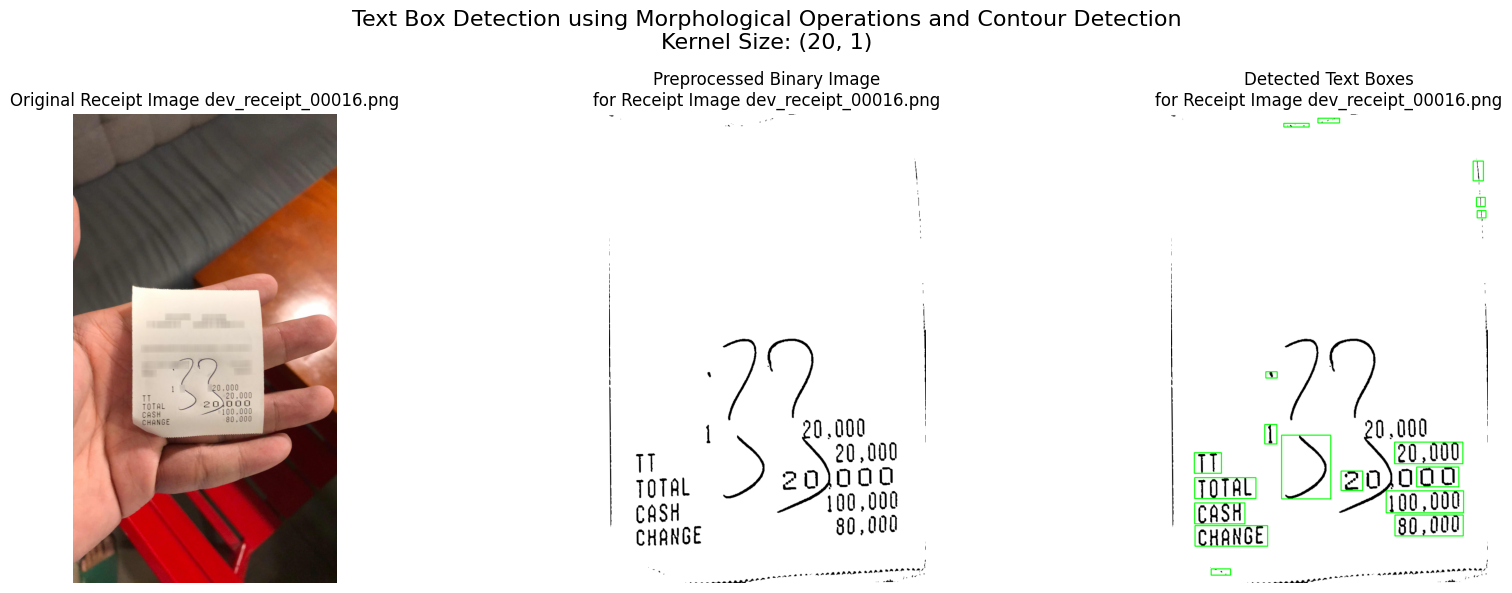

In [197]:
image = 'dev_receipt_00016'

# Load a binary image
binary_image = cv2.imread(os.path.join(data_dir, f'{image}.png'), cv2.IMREAD_GRAYSCALE)

# Apply the text box detection
empirical_kernel = (20, 1)
text_boxes = detect_text_boxes(binary_image, kernel_size=empirical_kernel)

# Print shape of detected boxes
print(f"Detected {len(text_boxes)} text boxes.")

# Visualize the detected text boxes
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
# IMREAD RGB to display correctly with matplotlib
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join("../data/images", f'{image}.png')), cv2.COLOR_BGR2RGB))
plt.title(f'Original Receipt Image {image}.png')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title(f'Preprocessed Binary Image\nfor Receipt Image {image}.png')
plt.axis('off')
plt.subplot(1, 3, 3)
image_with_boxes = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
for (x, y, w, h) in text_boxes:
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(image_with_boxes)
plt.title(f'Detected Text Boxes\nfor Receipt Image {image}.png')
plt.axis('off')
plt.suptitle(f'Text Box Detection using Morphological Operations and Contour Detection\nKernel Size: {empirical_kernel}', fontsize=16)
plt.tight_layout()
plt.savefig(f'../reports/figures/detected_text_boxes_{image}.png')
plt.show()